## Multivariate Time Series Forecasting with LSTMs in Keras
### Adapted from:
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- ~/TimeSeriesExperimentation/01_TimeSeriesToSupervisedLearningProblem

## Introduction
- Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.
- This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.
- In this tutorial, you will discover how you can develop an LSTM model for multivariate time series forecasting in the Keras deep learning library.

In [24]:
%reset -f

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics

# Other
from datetime import datetime

%matplotlib inline

### 1. Air Pollution Forecasting

- In this tutorial, we are going to use the Air Quality dataset.
- This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
- The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:
    - No: row number
    - year: year of data in this row
    - month: month of data in this row
    - day: day of data in this row
    - hour: hour of data in this row
    - pm2.5: PM2.5 concentration
    - DEWP: Dew Point
    - TEMP: Temperature
    - PRES: Pressure
    - cbwd: Combined wind direction
    - Iws: Cumulated wind speed
    - Is: Cumulated hours of snow
    - Ir: Cumulated hours of rain
- We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

## 2. Basic Data Preparation
- The data is not ready to use. We must prepare it first.
- Below are the first few rows of the raw dataset:

In [25]:
dataset = pd.read_csv('raw.csv')

print dataset.head(10)

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5   6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6   7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7   8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8   9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9  10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0


- The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.
- A quick check reveals NaN values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first 24 rows of data. There are also a few scattered “NaN” values later in the dataset; we can mark them with 0 values for now.
- The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NaN values are replaced with “0” values and the first 24 hours are removed.

In [26]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],
                      index_col=0, date_parser=parse)

# Drop the 'No' column
dataset.drop('No', axis=1, inplace=True)

# Manually specify meaningful column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# Replace all NaN values with 0
dataset['pollution'].fillna(0, inplace=True)

# Drop the first 24 hours, i.e. first 24 data points
dataset = dataset[24:]

# Display the first 5 rows
print(dataset.head(5))

# Save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


- Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.
- The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed direction, which is categorical.

[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]


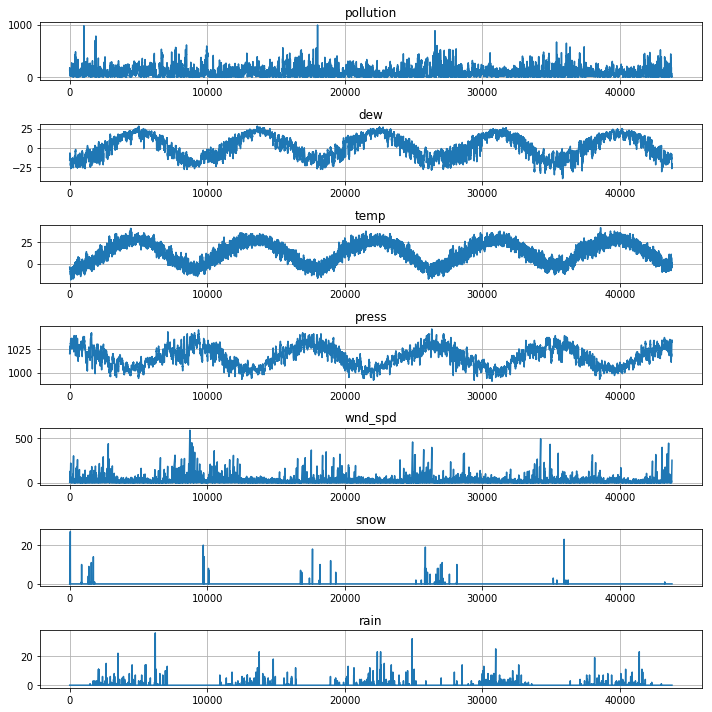

In [27]:
# Load the newly created pollution dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print values[0, :]
# Specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# Plot each column
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.grid()
    plt.plot(values[:, group])
    plt.title(dataset.columns[group])
    i += 1

fig.tight_layout()
plt.show()

## 3. Multivariate LSTM Forecast Model
- In this section, we will fit an LSTM to the problem.

### 3.1. LSTM Data Preparation
- The first step is to prepare the pollution dataset for the LSTM.
- This involves framing the dataset as a supervised learning problem and normalizing the input variables.
- We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.
- This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:
    - Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
    - Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.
- First, the “pollution.csv” dataset is loaded. The wind speed feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.
- Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [28]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [34]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = SklPreProcessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
lookBack = 1
lookAhead = 1
reframed = series_to_supervised(scaled, lookBack, lookAhead)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
# print reframed.keys()


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


- This data preparation is simple and there is more we could explore. Some ideas you could look at include:
    - One-hot encoding wind speed.
    - Making all series stationary with differencing and seasonal adjustment.
    - Providing more than 1 hour of input time steps.
- This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

### 3.2. Define and Fit Model
- In this section, we will fit an LSTM on the multivariate input data.
- First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. **If you have time, consider exploring the inverted version of this test harness.**
- The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [35]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 # 1 year
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print "train_X.shape: ", train_X.shape
print "train_y.shape: ", train_y.shape
print "---------------"
print "test_X.shape:  ", test_X.shape
print "test_y.shape:  ", test_y.shape

train_X.shape:  (8760, 1, 8)
train_y.shape:  (8760,)
---------------
test_X.shape:   (35039, 1, 8)
test_y.shape:   (35039,)


- Now we can define and fit our LSTM model.
- We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
- The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).
- Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [36]:
# design network
model = Sequential()

print (train_X.shape[1], train_X.shape[2])

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Visualize LSTM network
plot_model(model, to_file='model_1.png', show_shapes=True)

(1, 8)


In [37]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0576 - val_loss: 0.0579
Epoch 2/50
 - 1s - loss: 0.0417 - val_loss: 0.0580
Epoch 3/50
 - 1s - loss: 0.0261 - val_loss: 0.0474
Epoch 4/50
 - 1s - loss: 0.0177 - val_loss: 0.0358
Epoch 5/50
 - 1s - loss: 0.0154 - val_loss: 0.0194
Epoch 6/50
 - 1s - loss: 0.0149 - val_loss: 0.0155
Epoch 7/50
 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 8/50
 - 1s - loss: 0.0149 - val_loss: 0.0145
Epoch 9/50
 - 1s - loss: 0.0147 - val_loss: 0.0144
Epoch 10/50
 - 1s - loss: 0.0148 - val_loss: 0.0143
Epoch 11/50
 - 1s - loss: 0.0148 - val_loss: 0.0140
Epoch 12/50
 - 1s - loss: 0.0147 - val_loss: 0.0141
Epoch 13/50
 - 1s - loss: 0.0147 - val_loss: 0.0140
Epoch 14/50
 - 1s - loss: 0.0147 - val_loss: 0.0140
Epoch 15/50
 - 1s - loss: 0.0147 - val_loss: 0.0139
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0136
Epoch 17/50
 - 1s - loss: 0.0144 - val_loss: 0.0134
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0134
Epoch 19/50
 - 1s - loss

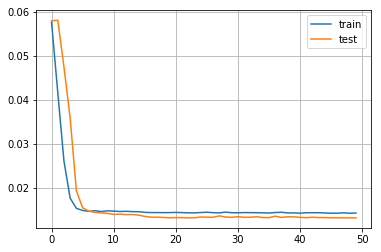

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend()
plt.show()

### 3.3. Evaluate Model
- After the model is fit, we can forecast for the entire test dataset.
- We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.
- With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.
- Running the example first creates a plot showing the train and test loss during training.
- Interestingly, we can see that test loss drops below training loss. The model may be overfitting the training data. Measuring and plotting RMSE during training may shed more light on this.
- The Train and test loss are printed at the end of each training epoch. At the end of the run, the final RMSE of the model on the test dataset is printed.
- We can see that the model achieves a respectable RMSE of 26.496, which is lower than an RMSE of 30 found with a persistence model.

In [39]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = mt.sqrt(SklMetrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.335


## Train On Multiple Lag Timesteps Example

In [40]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = SklPreProcessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 32)


- Next, we need to be more careful in specifying the column for input and output.
- We have 3 x 8 + 8 columns in our framed dataset. We will take 3 x 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

In [41]:
reframed.head(5)

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


In [42]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((8760, 24), 8760, (8760,))
((8760, 3, 8), (8760,), (35037, 3, 8), (35037,))


In [43]:
# design network
model = Sequential()

print (train_X.shape[1], train_X.shape[2])

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Visualize LSTM network
plot_model(model, to_file='model_2.png', show_shapes=True)

(3, 8)


In [44]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 1s - loss: 0.0456 - val_loss: 0.0664
Epoch 2/50
 - 1s - loss: 0.0251 - val_loss: 0.0413
Epoch 3/50
 - 1s - loss: 0.0213 - val_loss: 0.0287
Epoch 4/50
 - 1s - loss: 0.0210 - val_loss: 0.0279
Epoch 5/50
 - 1s - loss: 0.0204 - val_loss: 0.0251
Epoch 6/50
 - 1s - loss: 0.0195 - val_loss: 0.0202
Epoch 7/50
 - 1s - loss: 0.0191 - val_loss: 0.0196
Epoch 8/50
 - 1s - loss: 0.0187 - val_loss: 0.0189
Epoch 9/50
 - 1s - loss: 0.0184 - val_loss: 0.0190
Epoch 10/50
 - 1s - loss: 0.0178 - val_loss: 0.0180
Epoch 11/50
 - 1s - loss: 0.0171 - val_loss: 0.0178
Epoch 12/50
 - 1s - loss: 0.0167 - val_loss: 0.0179
Epoch 13/50
 - 1s - loss: 0.0162 - val_loss: 0.0177
Epoch 14/50
 - 1s - loss: 0.0158 - val_loss: 0.0184
Epoch 15/50
 - 1s - loss: 0.0155 - val_loss: 0.0183
Epoch 16/50
 - 1s - loss: 0.0152 - val_loss: 0.0184
Epoch 17/50
 - 1s - loss: 0.0151 - val_loss: 0.0176
Epoch 18/50
 - 1s - loss: 0.0150 - val_loss: 0.0176
Epoch 19/50
 - 1s - loss

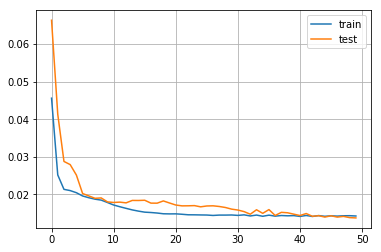

In [45]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()


In [46]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = mt.sqrt(SklMetrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.394
